# Algoritmo triangulación de Delaunay por flips

### Dependencias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import ConvexHull

### Funciones complementarias

In [2]:
# Calculate the Euclidean distance between two points p and q.
def dist(p, q):
    return sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)

# Compute the signed area of a triangle formed by points a, b, and c.
# The result is positive if the triangle is counter-clockwise, negative if clockwise, and zero if collinear.
def signed_area(a, b, c):
    return ((b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])) / 2

# Check if point d lies inside the circumcircle of the triangle formed by points a, b, and c.
# Returns True if point d is inside the circumcircle.
def in_circle(a, b, c, d):

    t = np.array([[1, 1, 1], [a[0], b[0], c[0]], [a[1], b[1], c[1]]])
    dt = np.linalg.det(t)
    if dt == 0:
        raise ValueError("Points are collinear")
    m = np.array(
        [
            [1, 1, 1, 1],
            [a[0], b[0], c[0], d[0]],
            [a[1], b[1], c[1], d[1]],
            [
                a[0] ** 2 + a[1] ** 2,
                b[0] ** 2 + b[1] ** 2,
                c[0] ** 2 + c[1] ** 2,
                d[0] ** 2 + d[1] ** 2,
            ],
        ]
    )
    dm = np.linalg.det(m)

    return dt * dm < -0.001


def angular_order(points, center):
    """
    Sorts a set of points in angular order around a given center point.

    This function partitions the points into four groups based on their 
    relative position to the center point: right (east), left (west), 
    above (north), and below (south). Each group is then sorted according 
    to their angular position with respect to the center and, in case of ties, 
    by their distance from the center.
    """
    right = []    # Points to the right of the center
    left = []     # Points to the left of the center
    above = []    # Points directly above the center
    below = []    # Points directly below the center

    # Partition points into four groups based on their position relative to the center.
    for point in points:
        if point[0] > center[0]:
            right.append(point)
        elif point[0] < center[0]:
            left.append(point)
        elif point[0] == center[0] and point[1] > center[1]:
            above.append(point)
        elif point[0] == center[0] and point[1] < center[1]:
            below.append(point)

    # Sort each group:
    # - By angular position relative to the center (calculated using slope).
    # - By distance to the center in case of angular ties.
    right = sorted(right, key=lambda x: [(x[1] - center[1]) / (x[0] - center[0]), dist(x, center)])
    left = sorted(left, key=lambda x: [(x[1] - center[1]) / (x[0] - center[0]), dist(x, center)])
    above = sorted(above)  # Points directly above are sorted by y-coordinate.
    below = sorted(below)  # Points directly below are sorted by y-coordinate.

    # Combine sorted groups into the final angular order.
    # If the center point is in the input set, include it as the first element.
    if center in points:
        return [center] + right + above + left + below
    else:
        return right + above + left + below

def get_opposite_vertex(triangle, edge):
    """
    Finds the vertex in a triangle that is not part of a given edge.
    """
    for vertex in triangle:
        # Check if the vertex is not one of the points in the edge.
        if vertex != edge[0] and vertex != edge[1]:
            return vertex


def flips(edge_1, edge_2, opposite_point1, opposite_point2):
    """
    Performs a flip operation in a triangulation and returns the two new triangles.

    A "flip" replaces two adjacent triangles sharing a common edge with two new triangles 
    that share a new edge formed by connecting the opposite vertices of the original triangles.
    """
    # Create the two new triangles after the flip
    triangle_1 = [edge_1, opposite_point1, opposite_point2]
    triangle_2 = [edge_2, opposite_point1, opposite_point2]

    return triangle_1, triangle_2


def graham_triangulation(points):
    """
    Constructs a triangulation of a set of points using the Graham scan algorithm.

    This function computes a triangulation by sorting points in angular order 
    around the leftmost point (or the lowest point in case of ties) and 
    iteratively building triangles based on their orientation.
    """
    
    triangulation = []  # List to store the resulting triangles.

    # If there are fewer than three points, return the points themselves as a single "triangle."
    if len(points) < 3:
        return [points]

    # Find the leftmost (or lowest) point to serve as the reference.
    origin = min(points)

    # Sort points in angular order around the reference point.
    sorted_points = angular_order(points, origin)

    # Create initial set of triangles from sorted points.
    for i in range(1, len(sorted_points) - 1):
        triangulation.append([sorted_points[0], sorted_points[i], sorted_points[i + 1]])

    # Refine the triangulation by checking for counter-clockwise orientation.
    i = 1
    while sorted_points[i] != sorted_points[-1]:
        if signed_area(sorted_points[i - 1], sorted_points[i], sorted_points[(i + 1) % len(sorted_points)]) < 0:
            # If the area is negative, points are not counter-clockwise; add a triangle and remove the middle point.
            triangulation.append([sorted_points[i], sorted_points[(i + 1) % len(sorted_points)], sorted_points[i - 1]])
            sorted_points.pop(i)

            # Move back one step if possible.
            if i > 0:
                i -= 1
        else:
            # Points are counter-clockwise; continue to the next set.
            i += 1

    return triangulation

def check_points_aligned(P, i):
    """
    Adjusts the points in a point cloud to ensure no three points are collinear.

    Parameters:
    ----------
    P : list of lists
        A point cloud represented as a list of points, where each point is [x, y].
    i : int
        Index of the point with the smallest x-coordinate in the point cloud.

    Returns:
    -------
    list of lists
        The modified point cloud where no three points are collinear.
    
    Notes:
    ------
    - The function checks if any three points, including the point at index `i`,
      are collinear by calculating the signed area of the triangle they form.
    - If three points are collinear, a small random perturbation is added to the 
      coordinates of the third point to break collinearity.
    - The signed area of a triangle formed by points A, B, and C is zero if the 
      points are collinear.

    Example:
    --------
    >>> P = [[0, 0], [1, 1], [2, 2], [3, 3]]
    >>> i = 0  # Index of the point with the smallest x-coordinate
    >>> check_points_aligned(P, i)
    [[0, 0], [1, 1], [2.0002, 2.0003], [3.0001, 3.0004]]
    """
    
    n = len(P)
    
    for j in range(n):
        if j != i:
            for k in range(n):
                if k != i and k != j: 
                    if signed_area(P[i], P[j], P[k]) == 0:
                        print(f"{P[i]}, {P[j]}, {P[k]} are collinear.")
                        P[k][0] = P[k][0] + random.random() * 0.001
                        P[k][1] = P[k][1] + random.random() * 0.001
                        
    return P

### Algoritmo triangulación por flips

In [8]:
def delaunay_triangulation_flips(points):
    """
    Computes a Delaunay triangulation of a set of 2D points using an iterative refinement process.

    The function starts with an initial triangulation obtained from the Graham scan and 
    incrementally refines it by performing edge flips to ensure the Delaunay condition is satisfied.

    Args:
        points (list of tuples): A list of 2D points represented as (x, y).

    Returns:
        list of lists: A list of triangles, where each triangle is represented as a list of three vertices (x, y).

    Example:
        points = [(0, 0), (1, 0), (0, 1), (1, 1)]
        triangulation(points)
        # Returns a Delaunay triangulation, e.g.:
        # [[(0, 0), (1, 0), (0, 1)], [(1, 0), (1, 1), (0, 1)]]
    """
    
    # Find the index of the point with the smallest x-coordinate (used as the reference point for Graham's triangulation)
    index_xmin = points.index(min(points))
    
    # Ensure that no two other points are collinear with the reference point to avoid issues during triangulation
    points = check_points_aligned(points, index_xmin)
    
    # Compute the convex hull of the points (used to identify boundary edges).
    convex_hull = ConvexHull(points).simplices.tolist()

    # Start with an initial triangulation using Graham's method.
    previous_triangulation = graham_triangulation(points)

    # Flag to track if any changes were made during the current iteration.
    change_occurred = True
    triangulations = [previous_triangulation]
    while change_occurred:
        change_occurred = False
        current_triangulation = previous_triangulation.copy()

        # Iterate over each triangle in the triangulation.
        for triangle in previous_triangulation:
            # Check each edge of the triangle (3 edges total).
            for i in range(-1, 2):
                # Skip edges that are part of the convex hull.
                if triangle[i] in convex_hull and triangle[i + 1] in convex_hull:
                    pass
                else:
                    # Look for a neighboring triangle that shares the current edge.
                    for other_triangle in previous_triangulation:
                        if triangle != other_triangle and triangle[i] in other_triangle and triangle[i + 1] in other_triangle:
                            # Find the opposite vertices in both triangles.
                            opposite_vertex1 = get_opposite_vertex(triangle, [triangle[i], triangle[i + 1]])
                            opposite_vertex2 = get_opposite_vertex(other_triangle, [triangle[i], triangle[i + 1]])

                            # Check if the Delaunay condition is violated.
                            if in_circle(triangle[i], triangle[i + 1], opposite_vertex1, opposite_vertex2):
                                # Perform an edge flip.
                                new_triangle1, new_triangle2 = flips(triangle[i], triangle[i + 1], opposite_vertex1, opposite_vertex2)
                                change_occurred = True

                                # Remove the original triangles from the triangulation.
                                current_triangulation.pop(current_triangulation.index(triangle))
                                current_triangulation.pop(current_triangulation.index(other_triangle))

                                # Add the new flipped triangles to the triangulation.
                                current_triangulation.append(new_triangle1)
                                current_triangulation.append(new_triangle2)

                        # If a change occurred, stop processing further edges.
                        if change_occurred:
                            break

                # If a change occurred, stop processing further triangles.
                if change_occurred:
                    break

            # If a change occurred, stop the loop and restart the process.
            if change_occurred:
                break

        # Update the triangulation for the next iteration.
        previous_triangulation = current_triangulation.copy()
        triangulations.append(current_triangulation.copy())
    return triangulations


### Test  

In [4]:
def test_delaunay(triangulation, points):
    """
    Test that verifies the Delaunay condition for each triangle in the triangulation.

    This function checks that no point from the set of points lies inside the circumcircle
    of any triangle in the triangulation. If a violation of the Delaunay condition is found,
    it reports the problematic point and triangle.

    Args:
        triangulation (list of lists): A list of triangles, where each triangle is represented
                                       as a list of three vertices (x, y).
        points (list of tuples): A list of 2D points represented as (x, y).

    Example:
        points = [(0, 0), (1, 0), (0, 1), (1, 1), (0.5, 0.5)]
        triangulation = [[(0, 0), (1, 0), (0, 1)], [(1, 0), (1, 1), (0, 1)]]
        test_delaunay(triangulation, points)
        # Prints any Delaunay violations.
    """
    for triangle in triangulation:
        p1, p2, p3 = triangle[0], triangle[1], triangle[2]

        # Check if any other point lies inside the circumcircle of the triangle.
        for point in points:
            if point not in [p1, p2, p3]:
                if in_circle(p1, p2, p3, point):
                    print(
                        f"Error: Point {point} lies inside the circumcircle of the "
                        f"triangle formed by points {p1}, {p2}, {p3}."
                    )

def visualize_triangulation(triangulation, points):
    """
    Visualizes a Delaunay triangulation using Matplotlib.

    This function takes a set of points and their corresponding triangulation
    and plots the triangles and points on a 2D plane.

    Args:
        triangulation (list of lists): A list of triangles, where each triangle is represented
                                       as a list of three vertices (x, y).
        points (list of tuples): A list of 2D points represented as (x, y).

    Example:
        points = [(0, 0), (1, 0), (0, 1), (1, 1), (0.5, 0.5)]
        triangulation = [[(0, 0), (1, 0), (0, 1)], [(1, 0), (1, 1), (0, 1)]]
        visualize_triangulation(triangulation, points)
    """
    fig, ax = plt.subplots()

    # Draw the triangles
    for triangle in triangulation:
        # Create a closed polygon for each triangle
        x = [p[0] for p in triangle]
        y = [p[1] for p in triangle]
        x.append(triangle[0][0])  # Close the triangle
        y.append(triangle[0][1])  # Close the triangle
        ax.plot(x, y, 'b-')  # Draw triangle edges in blue

    # Draw the points
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]
    ax.scatter(x_points, y_points, color='red', zorder=5)  # Plot points in red

    # Configure the axes
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(True)
    plt.title("Visualization of Delaunay Triangulation")
    plt.show()


    




[0, 0], [1, 1], [2, 2] are collinear.


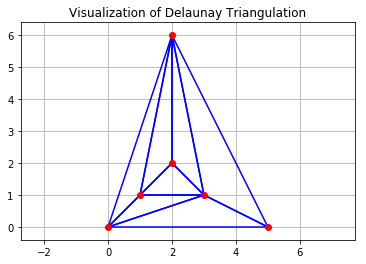

In [5]:
points=[[0,0],[1,1],[2,2],[3,1],[5,0], [2, 6]]

triangulation = delaunay_triangulation_flips(points)
visualize_triangulation(triangulation, points)

In [6]:
@interact
def delaunay_show(S = selector([[[0, -1], [3, 0], [-1, 2], [2, 1], [1, 0], [2, 2]]])):
    points = S
    
    triangulation = delaunay_triangulation_flips(points)
    visualize_triangulation(triangulation, points)

Interactive function <function delaunay_show at 0x6fb78f1c510> with 1 widget
  S: Dropdown(description='S', op…

4


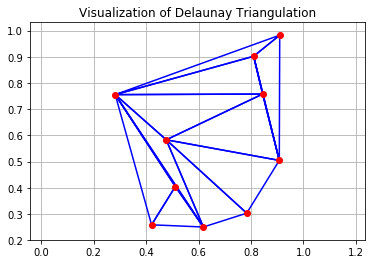

In [13]:
random.seed(0)
points = [[random.random(), random.random()] for _ in range(10)]

triangulations = delaunay_triangulation_flips(points)
print(len(triangulations))
n = slider([1..29])
visualize_triangulation(triangulations[3], points)

In [26]:
@interact
def delaunay_show(S = selector([[[0, -1], [3, 0], [-1, 2], [2, 1], [1, 0], [2, 2]]])):
    points = S
    points = [[random.random(), random.random()] for _ in range(10)]
    triangulation = delaunay_triangulation_flips(points)
    @interact
    def show(n = slider[1..len(triangulation)-1]):
        
        visualize_triangulation(triangulation[n], points)

Interactive function <function delaunay_show at 0x6fb70926ea0> with 1 widget
  S: Dropdown(description='S', op…